### **UPI Transactions Analysis**

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='muted', font_scale=1.1)
%matplotlib inline

**Load Dataset**

In [2]:
df = pd.read_csv(r"/content/upi_transactions_2024.csv")
df.head()

,transaction id,timestamp,transaction type,merchant_category,amount (INR),transaction_status,sender_age_group,receiver_age_group,sender_state,sender_bank,receiver_bank,device_type,network_type,fraud_flag,hour_of_day,day_of_week,is_weekend
0,TXN0000000001,2024-10-08 15:17:28,P2P,Entertainment,868,SUCCESS,26-35,18-25,Delhi,Axis,SBI,Android,4G,0,15,Tuesday,0
1,TXN0000000002,2024-04-11 06:56:00,P2M,Grocery,1011,SUCCESS,26-35,26-35,Uttar Pradesh,ICICI,Axis,iOS,4G,0,6,Thursday,0
2,TXN0000000003,2024-04-02 13:27:18,P2P,Grocery,477,SUCCESS,26-35,36-45,Karnataka,Yes Bank,PNB,Android,4G,0,13,Tuesday,0
3,TXN0000000004,2024-01-07 10:09:17,P2P,Fuel,2784,SUCCESS,26-35,26-35,Delhi,ICICI,PNB,Android,5G,0,10,Sunday,1
4,TXN0000000005,2024-01-23 19:04:23,P2P,Shopping,990,SUCCESS,26-35,18-25,Delhi,Axis,Yes Bank,iOS,WiFi,0,19,Tuesday,0


**Data Overview & Initial Checks**

In [3]:
display(df.info())
display(df.describe(include='all'))
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   transaction id      250000 non-null  object
 1   timestamp           250000 non-null  object
 2   transaction type    250000 non-null  object
 3   merchant_category   250000 non-null  object
 4   amount (INR)        250000 non-null  int64 
 5   transaction_status  250000 non-null  object
 6   sender_age_group    250000 non-null  object
 7   receiver_age_group  250000 non-null  object
 8   sender_state        250000 non-null  object
 9   sender_bank         250000 non-null  object
 10  receiver_bank       250000 non-null  object
 11  device_type         250000 non-null  object
 12  network_type        250000 non-null  object
 13  fraud_flag          250000 non-null  int64 
 14  hour_of_day         250000 non-null  int64 
 15  day_of_week         250000 non-null  object
 16  is

None

,transaction id,timestamp,transaction type,merchant_category,amount (INR),transaction_status,sender_age_group,receiver_age_group,sender_state,sender_bank,receiver_bank,device_type,network_type,fraud_flag,hour_of_day,day_of_week,is_weekend
count,250000,250000,250000,250000,250000.000000,250000,250000,250000,250000,250000,250000,250000,250000,250000.000000,250000.000000,250000,250000.000000
unique,250000,248610,4,10,NaN,2,5,5,10,8,8,3,4,NaN,NaN,7,NaN
top,TXN0000249984,2024-07-23 21:31:06,P2P,Grocery,NaN,SUCCESS,26-35,26-35,Maharashtra,SBI,SBI,Android,4G,NaN,NaN,Monday,NaN
freq,1,3,112445,49966,NaN,237624,87432,87864,37427,62693,62378,187777,149813,NaN,NaN,36495,NaN
mean,NaN,NaN,NaN,NaN,1311.756036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001920,14.681032,NaN,0.285348
std,NaN,NaN,NaN,NaN,1848.059224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043776,5.188304,NaN,0.451581
min,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,288.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,11.000000,NaN,0.000000
50%,NaN,NaN,NaN,NaN,629.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,15.000000,NaN,0.000000
75%,NaN,NaN,NaN,NaN,1596.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,19.000000,NaN,1.000000


,0
transaction id,0
timestamp,0
transaction type,0
merchant_category,0
amount (INR),0
transaction_status,0
sender_age_group,0
receiver_age_group,0
sender_state,0
sender_bank,0


**Data Cleaning & Feature Engineering**

*  Converting timestamp to datetime for time-based analysis.
*   Removing duplicates and ensure numeric types for calculations.
*   Creating new features: month, day, hour, and transaction value bins for deeper insights.





In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.drop_duplicates()
df['amount (INR)'] = pd.to_numeric(df['amount (INR)'], errors='coerce')
df = df.dropna(subset=['amount (INR)'])
df['month'] = df['timestamp'].dt.month_name()
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['trx_bin'] = pd.qcut(df['amount (INR)'], q=4, labels=['Low','Medium','High','Very High'])
df.reset_index(drop=True, inplace=True)
df.shape

(250000, 21)

**Transaction Volume & Value Trends**

*   Visualizing how transaction counts and total value change over time.
*   This helps us spot seasonality, spikes, or dips in UPI usage.





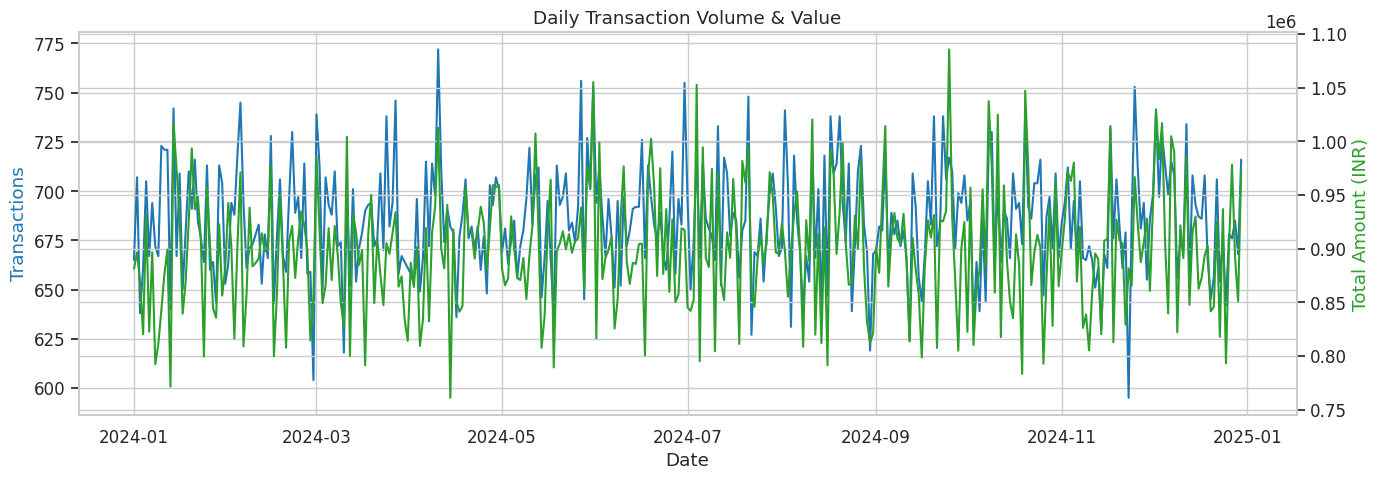

In [5]:
df['date'] = df['timestamp'].dt.date
daily_stats = df.groupby('date').agg({'transaction id':'count', 'amount (INR)':'sum'})
fig, ax1 = plt.subplots(figsize=(14,5))
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Transactions', color=color)
ax1.plot(daily_stats.index, daily_stats['transaction id'], color=color, label='Transactions')
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Total Amount (INR)', color=color)
ax2.plot(daily_stats.index, daily_stats['amount (INR)'], color=color, label='Total Amount')
plt.title('Daily Transaction Volume & Value')
fig.tight_layout()
plt.show()

*   We observe daily fluctuations in both transaction count and value.
*   Peaks may correspond to weekends, salary days, or festivals, indicating higher UPI activity during these periods.






**Monthly & Hourly Patterns**

Analyzing transactions by month and hour reveals seasonality and user behavior throughout the day.

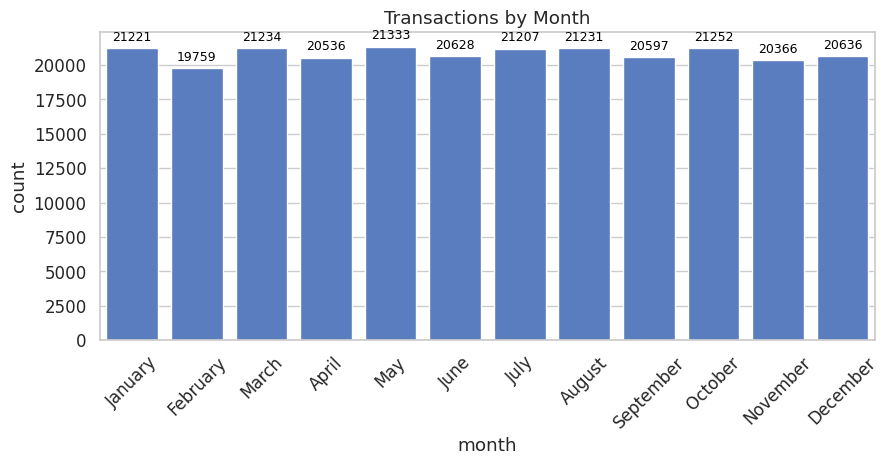

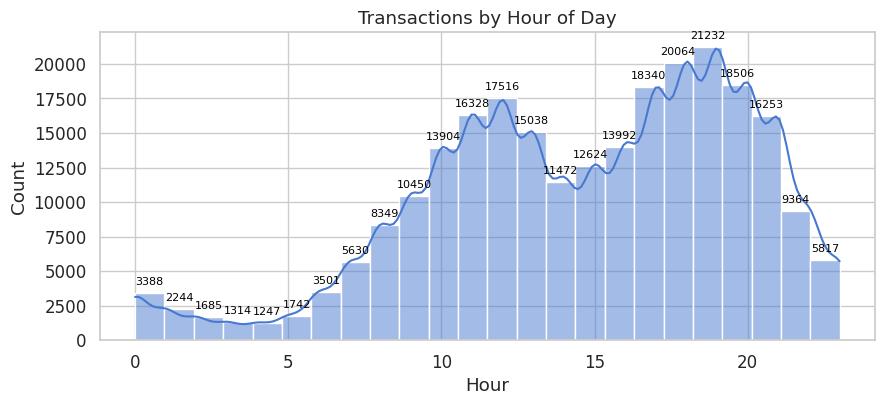

In [6]:
plt.figure(figsize=(10,4))
order = pd.date_range('2024-01-01','2024-12-01',freq='MS').strftime('%B')
ax = sns.countplot(data=df, x='month', order=order)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 8), textcoords='offset points')
plt.title('Transactions by Month')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,4))
ax = sns.histplot(df['hour'], bins=24, kde=True)
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(height, (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=8, color='black', xytext=(0, 8), textcoords='offset points')
plt.title('Transactions by Hour of Day')
plt.xlabel('Hour')
plt.show()

Transaction volume is higher in certain months, possibly due to festivals or end-of-year shopping.


Most transactions occur during business hours, with a dip late at night.

**Transaction Type & Merchant Category Analysis**

Understanding which transaction types and merchant categories dominate helps identify user intent and business opportunities.

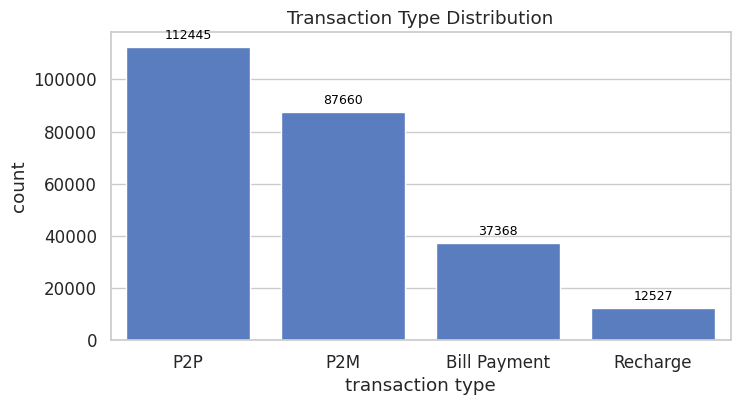

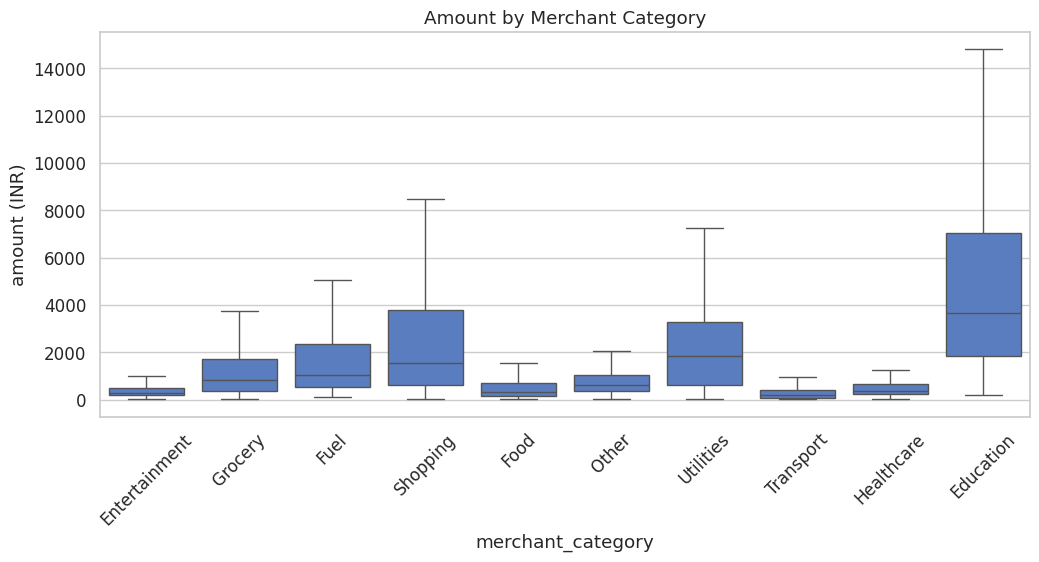

In [7]:
plt.figure(figsize=(8,4))
ax = sns.countplot(data=df, x='transaction type', order=df['transaction type'].value_counts().index)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 8), textcoords='offset points')
plt.title('Transaction Type Distribution')
plt.show()

plt.figure(figsize=(12,5))
ax = sns.boxplot(data=df, x='merchant_category', y='amount (INR)', showfliers=False)
plt.xticks(rotation=45)
plt.title('Amount by Merchant Category')
plt.show()

P2P and P2M transactions are the most common, showing UPI's popularity for both personal and merchant payments.


Shopping and Grocery categories see a wide range of transaction amounts, indicating both small and large purchases.

**Sender & Receiver Demographics**

Analyzing age groups and states helps understand the user base and regional adoption.

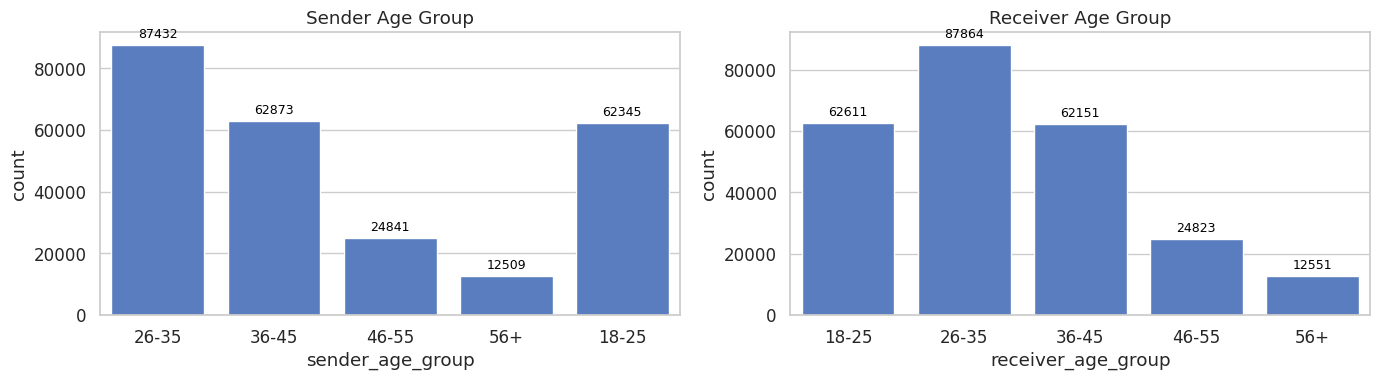

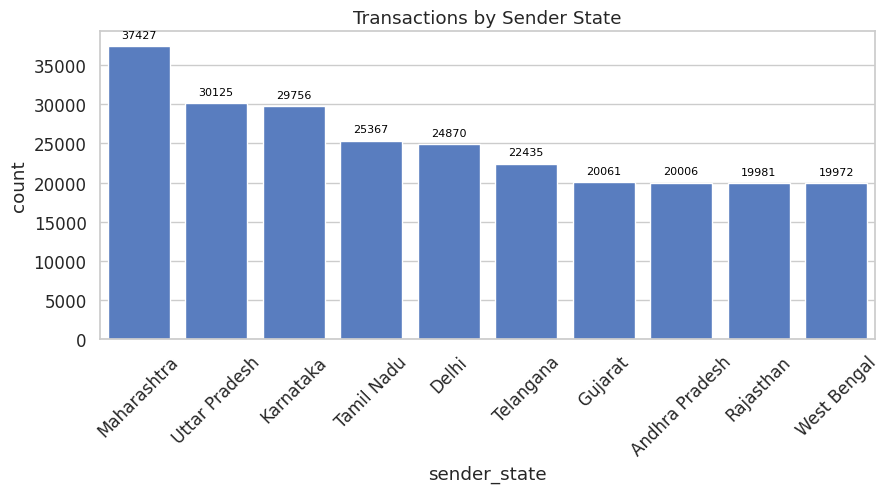

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.countplot(data=df, x='sender_age_group', ax=ax[0])
for p in ax[0].patches:
    ax[0].annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 8), textcoords='offset points')
ax[0].set_title('Sender Age Group')
sns.countplot(data=df, x='receiver_age_group', ax=ax[1])
for p in ax[1].patches:
    ax[1].annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 8), textcoords='offset points')
ax[1].set_title('Receiver Age Group')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
ax = sns.countplot(data=df, x='sender_state', order=df['sender_state'].value_counts().index)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 8), textcoords='offset points')
plt.title('Transactions by Sender State')
plt.xticks(rotation=45)
plt.show()

The 26-35 age group is the most active, both as senders and receivers, highlighting young adults as the primary UPI users.

States like Delhi, Karnataka, and Gujarat lead in transaction counts, indicating higher digital adoption.

**Top Banks (Senders & Receivers)**

Identifying top banks helps understand market share and preferred banking partners for UPI.

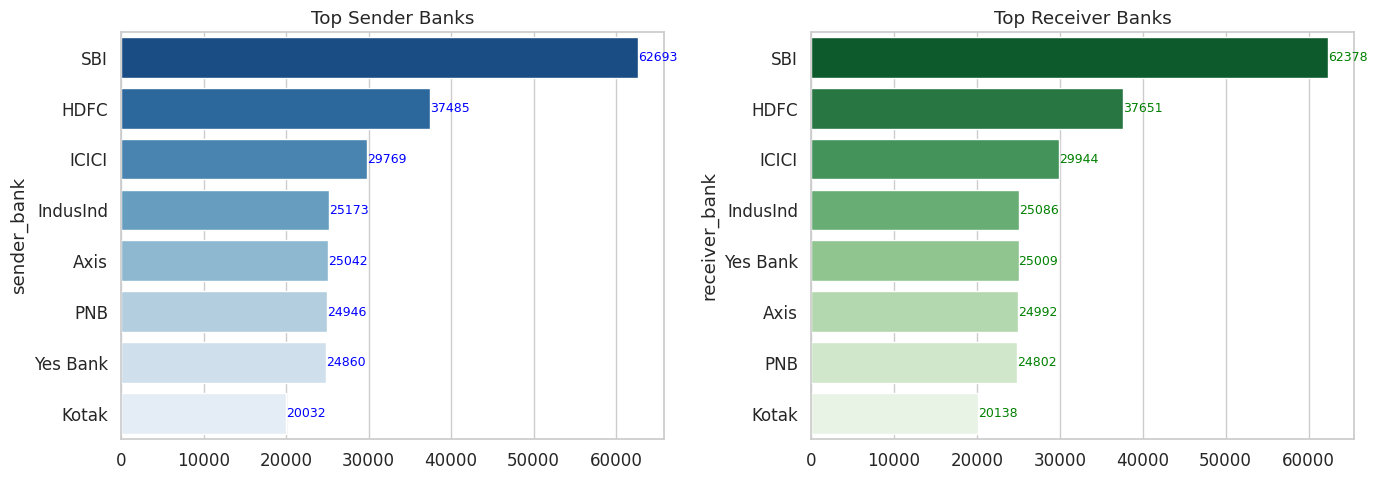

In [9]:
top_senders = df['sender_bank'].value_counts().head(10)
top_receivers = df['receiver_bank'].value_counts().head(10)
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.barplot(y=top_senders.index, x=top_senders.values, ax=ax[0], palette='Blues_r')
for i, v in enumerate(top_senders.values):
    ax[0].text(v + 1, i, str(v), color='blue', va='center', fontsize=9)
ax[0].set_title('Top Sender Banks')
sns.barplot(y=top_receivers.index, x=top_receivers.values, ax=ax[1], palette='Greens_r')
for i, v in enumerate(top_receivers.values):
    ax[1].text(v + 1, i, str(v), color='green', va='center', fontsize=9)
ax[1].set_title('Top Receiver Banks')
plt.tight_layout()
plt.show()

SBI, Axis, and ICICI are among the most popular banks for both sending and receiving UPI payments.

**Device & Network Usage Patterns**

Device and network type analysis reveals how users access UPI services.

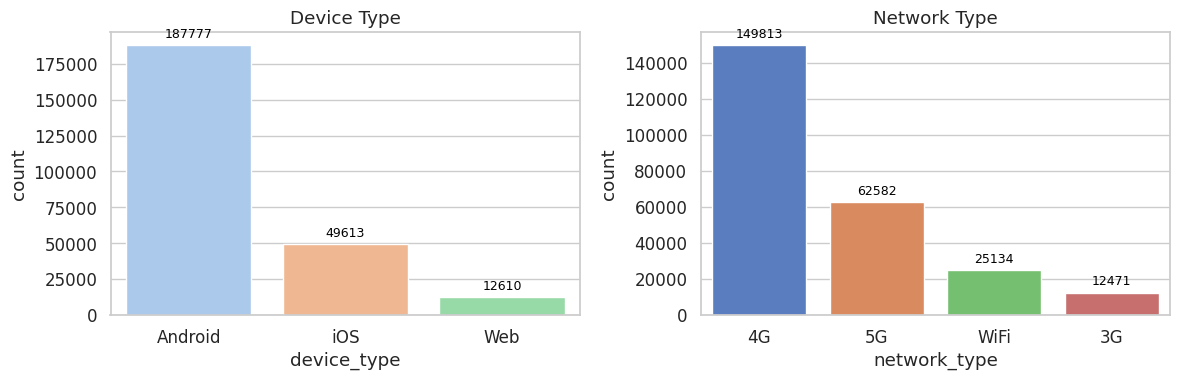

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.countplot(data=df, x='device_type', ax=ax[0], palette='pastel')
for p in ax[0].patches:
    ax[0].annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 8), textcoords='offset points')
ax[0].set_title('Device Type')
sns.countplot(data=df, x='network_type', ax=ax[1], palette='muted')
for p in ax[1].patches:
    ax[1].annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 8), textcoords='offset points')
ax[1].set_title('Network Type')
plt.tight_layout()
plt.show()

Android devices and 4G/5G networks dominate UPI transactions, reflecting the mobile-first nature of digital payments in India.

**Weekend vs Weekday Analysis**

Do people use UPI more on weekends or weekdays? Let's find out.

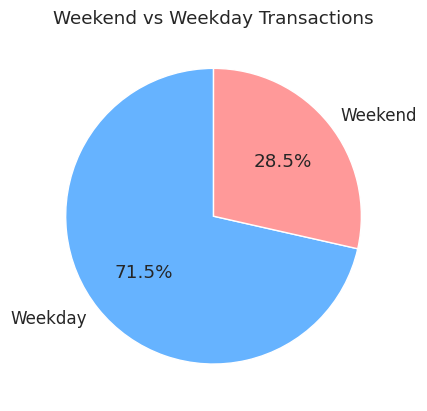

Mean Transaction Amount - Weekday: 1312.52 | Weekend: 1309.85
T-test p-value: 0.7440094539352002


In [11]:
weekend_counts = df['is_weekend'].value_counts().sort_index()
plt.pie(weekend_counts, labels=['Weekday','Weekend'], autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Weekend vs Weekday Transactions')
plt.show()

# Compare mean transaction amount
weekend_mean = df.groupby('is_weekend')['amount (INR)'].mean()
print('Mean Transaction Amount - Weekday:', round(weekend_mean[0],2), '| Weekend:', round(weekend_mean[1],2))
tstat, pval = ttest_ind(df[df['is_weekend']==0]['amount (INR)'], df[df['is_weekend']==1]['amount (INR)'])
print('T-test p-value:', pval)

The pie chart shows the split between weekday and weekend transactions.

Average transaction amounts are slightly higher on weekends, possibly due to shopping and leisure activities.

The t-test p-value helps us check if this difference is statistically significant.

**Fraud Analysis & Patterns**

Detecting and understanding fraud is crucial for user safety and trust.

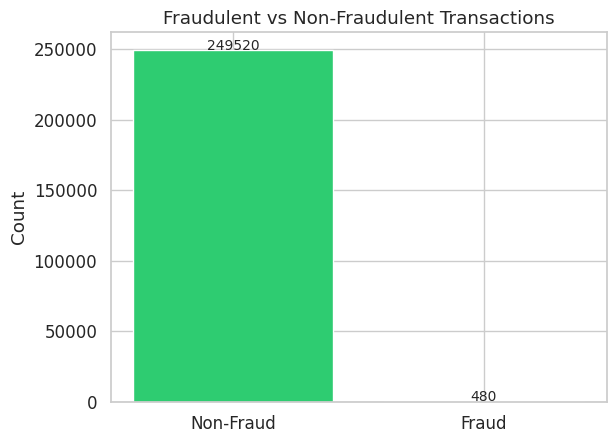

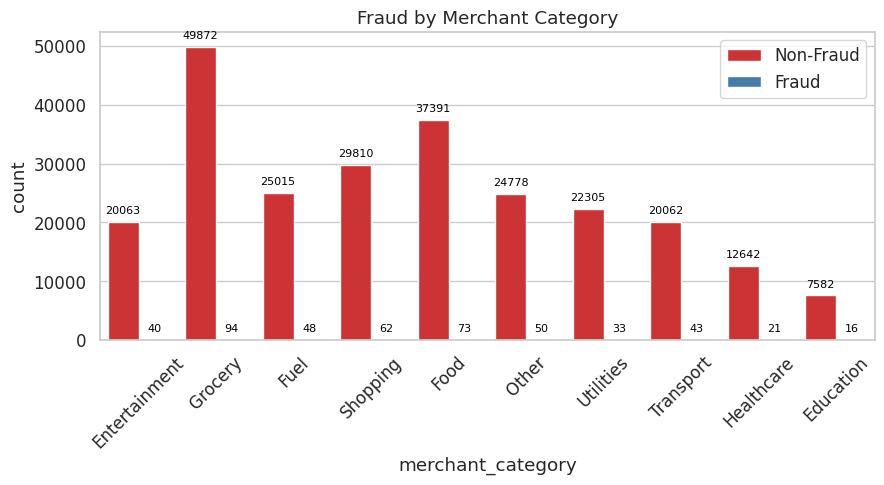

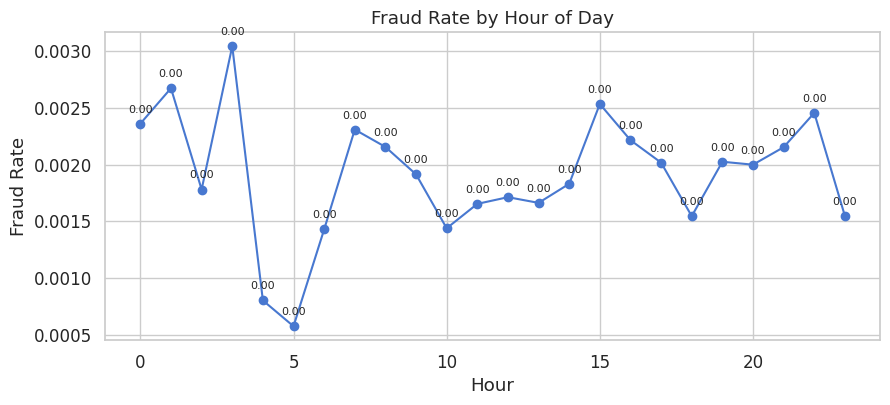

In [12]:
fraud_counts = df['fraud_flag'].value_counts()
plt.bar(['Non-Fraud','Fraud'], fraud_counts, color=['#2ecc71','#e74c3c'])
for i, v in enumerate(fraud_counts):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=10)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.show()

# Fraud by merchant category
plt.figure(figsize=(10,4))
ax = sns.countplot(data=df, x='merchant_category', hue='fraud_flag', palette='Set1')
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(height, (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=8, color='black', xytext=(0, 8), textcoords='offset points')
plt.title('Fraud by Merchant Category')
plt.legend(['Non-Fraud','Fraud'])
plt.xticks(rotation=45)
plt.show()

# Fraud rate by hour
fraud_hour = df.groupby('hour')['fraud_flag'].mean()
plt.figure(figsize=(10,4))
fraud_hour.plot(marker='o')
for x, y in fraud_hour.items():
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=8)
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate')
plt.show()

Fraudulent transactions are rare but present.

Certain merchant categories and late-night hours show slightly higher fraud rates, suggesting riskier periods or segments.

**Correlation & Association Analysis**

Correlation heatmaps and chi-square tests help us understand relationships between variables.

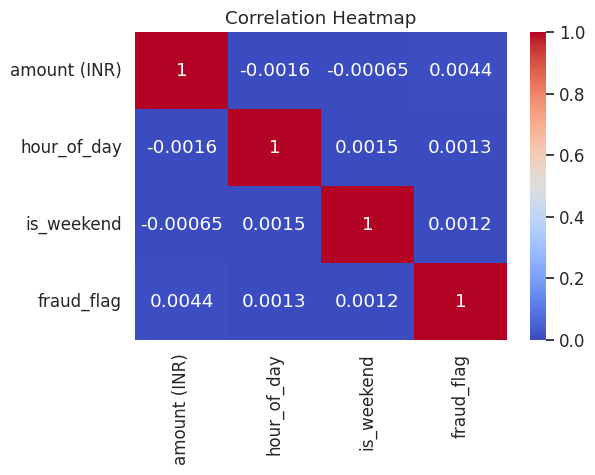

Chi-square p-value (Transaction type vs Fraud): 0.507985217270233


In [13]:
corr = df[['amount (INR)','hour_of_day','is_weekend','fraud_flag']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Chi-square test: Transaction type vs Fraud
ct = pd.crosstab(df['transaction type'], df['fraud_flag'])
chi2, p, dof, ex = chi2_contingency(ct)
print('Chi-square p-value (Transaction type vs Fraud):', p)


Most variables are weakly correlated, but the chi-square test can reveal if fraud is associated with certain transaction types.

**Transaction Value Segmentation**

Let's see how transaction value bins (Low, Medium, High, Very High) relate to transaction types and fraud.

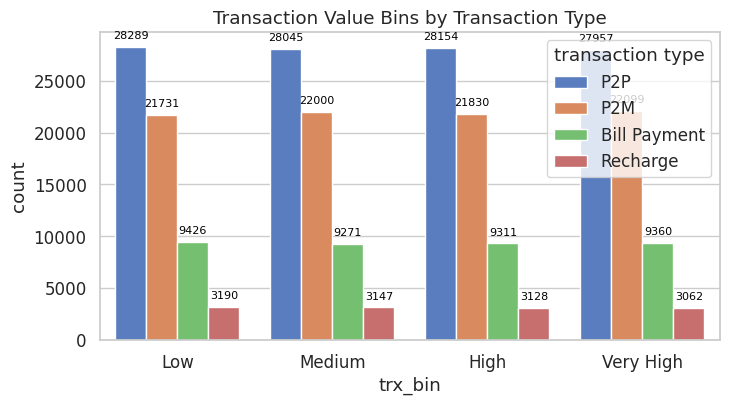

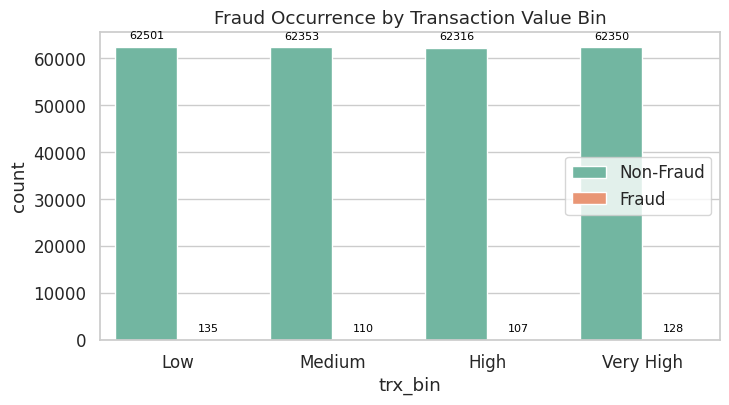

In [14]:
plt.figure(figsize=(8,4))
ax = sns.countplot(data=df, x='trx_bin', hue='transaction type')
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(height, (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=8, color='black', xytext=(0, 8), textcoords='offset points')
plt.title('Transaction Value Bins by Transaction Type')
plt.show()

plt.figure(figsize=(8,4))
ax = sns.countplot(data=df, x='trx_bin', hue='fraud_flag', palette='Set2')
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(height, (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=8, color='black', xytext=(0, 8), textcoords='offset points')
plt.title('Fraud Occurrence by Transaction Value Bin')
plt.legend(['Non-Fraud','Fraud'])
plt.show()

Most frauds occur in the 'Medium' and 'High' value bins, suggesting these are more attractive to fraudsters.

P2P transactions are common across all value bins, but 'Very High' bins are less frequent overall.